In [2]:
import glob

import numpy as np
from pylab import *
import sympy as sym
%matplotlib inline

def read_ps_voltage(file):
    read_data = np.genfromtxt(file, skip_header=1, delimiter=',')
    return read_data[:, 1]

# Messungen

Wir haben angefangen 20 verschiedene Entfernungen zu messen und diese mit der Picoscope Software in 20 einzelne CSV Dateien gespeichert.


In [3]:
files = glob.glob("cleaned/*cm*.csv")

# [reference in mm, all voltage values]
data = {
    100: read_ps_voltage(files[0]),
    130: read_ps_voltage(files[1]),
    160: read_ps_voltage(files[2]),
    180: read_ps_voltage(files[3]),
    220: read_ps_voltage(files[4]),
    245: read_ps_voltage(files[5]),
    250: read_ps_voltage(files[6]),
    280: read_ps_voltage(files[7]),
    300: read_ps_voltage(files[8]),
    340: read_ps_voltage(files[9]),
    380: read_ps_voltage(files[10]),
    410: read_ps_voltage(files[11]),
    460: read_ps_voltage(files[12]),
    490: read_ps_voltage(files[13]),
    520: read_ps_voltage(files[14]),
    580: read_ps_voltage(files[15]),
    620: read_ps_voltage(files[16]),
    650: read_ps_voltage(files[17]),
    # 690: read_ps_voltage(files[18]),
    # 710: read_ps_voltage(files[19]),
}

data_mean = {k: np.mean(v) for k, v in data.items()}

measurements = np.array(list(data_mean.items()))
distances = measurements[:, 0]
voltages = measurements[:, 1]

# Plotten und Logarithm

Wir können jetzt diese daten plotten. Sie haben die form $y = x^a$ deswegen müssen wir sie logarithmieren.


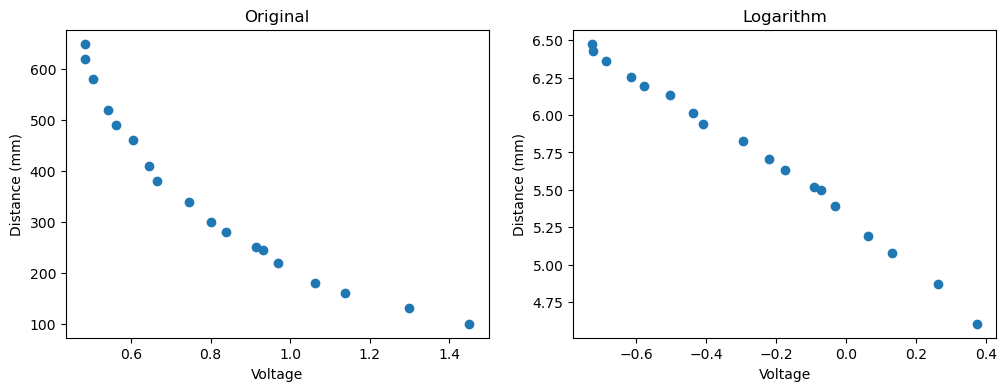

In [4]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 4))

ax1.set_title("Original")
ax1.set_ylabel("Distance (mm)")
ax1.set_xlabel("Voltage")
ax1.scatter(voltages, distances)

log_distances = np.log(distances)
log_voltages = np.log(voltages)

ax2.set_title("Logarithm")
ax2.set_ylabel("Distance (mm)")
ax2.set_xlabel("Voltage")
ax2.scatter(log_voltages, log_distances)

# Lineare Regression

Jetzt können wir für die lineare Regression $a$ und $b$ berechnen.

Wir verwenden:

$a=\frac{\sum_{i=1}^{n}(x_i-\bar{x})*(y_i-\bar{y})}{\sum_{i=1}^{n}(x_i-\bar{x})^2}$ und $b=\bar{y}-a*\bar{x}$


In [5]:
x = log_voltages
y = log_distances

x_mean = np.mean(x)
y_mean = np.mean(y)

a = np.divide(np.sum((x - x_mean) * (y - y_mean)),
              np.sum((x - x_mean) ** 2))

b = y_mean - a * x_mean

print("a =", a)
print("b =", b)

a = -1.6002993170761568
b = 5.308285702440343


Das plotten wir noch.


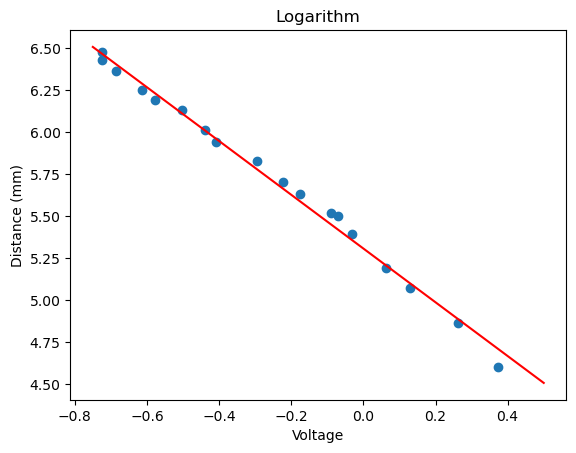

In [6]:
lin = np.linspace(-0.75, 0.5)
y_lin = a * lin + b

figure()

scatter(log_voltages, log_distances)
plot(lin, y_lin, 'r')

title("Logarithm")
ylabel("Distance (mm)")
xlabel("Voltage")
show()

Wir rechnen die lineare regression in eine exponentielle regression um indem wir $y = e^b * x^a$ anwenden.


In [7]:
def messungs_funktion(x):
    return np.exp(b) * x ** a

def dx_messungs_funktion(x):
    return a * np.exp(b) * x**(a-1)

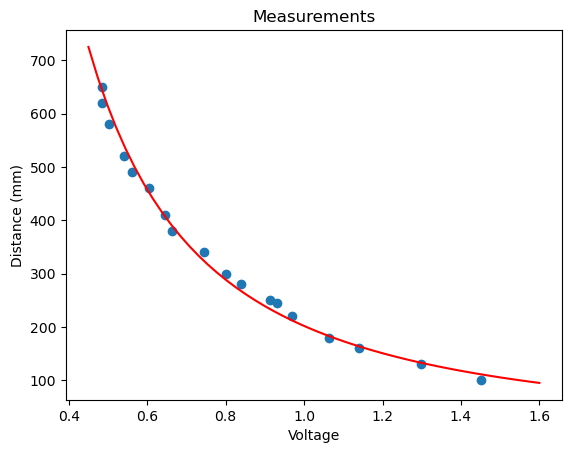

In [8]:
xc = np.linspace(0.45, 1.6)
yc = messungs_funktion(xc)
figure()
scatter(voltages, distances)
plot(xc, yc, 'r')
title("Measurements")
ylabel("Distance (mm)")
xlabel("Voltage")
show()

# Fehlerrechnung


In [9]:
def stdmean(x):
    return np.std(x) / np.sqrt(x.size)

In [10]:
# wahrer wert
dina4_breite_mm = 210

# gemessene werte
measured_dina4_breite = read_ps_voltage("./cleaned/dina4_breite_cleaned.csv")
measured_dina4_breite_mean = np.mean(measured_dina4_breite)

In [11]:
dina4_hoehe_mm = 297
measured_dina4_hoehe = read_ps_voltage("./cleaned/dina4_hoehe_cleaned.csv")
measured_dina4_hoehe_mean = np.mean(measured_dina4_hoehe)

# Vertrauensbereich

### 68 % Vertrauensbereich


In [12]:
gauss_68 = stdmean(measured_dina4_breite)
print("+-", str(gauss_68), "V")

def sicherheit_65(x):
    return np.array([np.mean(x) + stdmean(x), np.mean(x) - stdmean(x)])

print("breite", sicherheit_65(measured_dina4_breite))
print("höhe", sicherheit_65(measured_dina4_hoehe))

+- 0.00021179505854358662 V
breite [0.98798859 0.987565  ]
höhe [0.80185795 0.80144382]


### 95 % Vertrauensbereich


In [13]:
gauss_95 = 2 * stdmean(measured_dina4_breite)
print("+-", str(gauss_95), "V")

def sicherheit_95(x):
    return np.array([np.mean(x) + 1.98 * stdmean(x), np.mean(x) - 1.98 * stdmean(x)])

print("breite", sicherheit_95(measured_dina4_breite))
print("höhe", sicherheit_95(measured_dina4_hoehe))

+- 0.00042359011708717324 V
breite [0.98819615 0.98735744]
höhe [0.80206088 0.80124089]


# Messfehler

In [14]:
x = measured_dina4_breite_mean
measured_breite = messungs_funktion(x)
print("breite =", measured_breite, "mm")

# delta_x ist std
delta_x = np.std(measured_dina4_breite)
print("delta_x =", delta_x, "V")

delta_y = dx_messungs_funktion(x) * delta_x
print("delta_y =", delta_y, "mm")

print("\nFehlerfortpflanzung:", "von", measured_breite + delta_y, "mm", "bis", measured_breite - delta_y, "mm")

breite = 206.01871638795643 mm
delta_x = 0.006717610416243426 V
delta_y = -2.242146012770281 mm

Fehlerfortpflanzung: von 203.77657037518614 mm bis 208.26086240072672 mm


# Flächenmessung

Ein DIN A4 Blatt hat das Format $297 mm * 210 mm$

Die fläche sollte $62370mm^2$.


## Fläche Funktion

In [15]:
import sympy as sym
(x, x1, x2) = sym.symbols("x x1 x2")

m = sym.exp(b) * sym.Pow(x, a)
fl = m.subs(x, x1) * m.subs(x, x2)
fl

40805.4693816901/(x1**1.60029931707616*x2**1.60029931707616)

In [16]:
def dx1_fl(x1, x2):
    return a * np.exp(2*b) * x1**(a-1) * x2**a

def dx2_fl(x1, x2):
    return a * np.exp(2*b) * x1**(a) * x2**(a - 1)

## Messungen

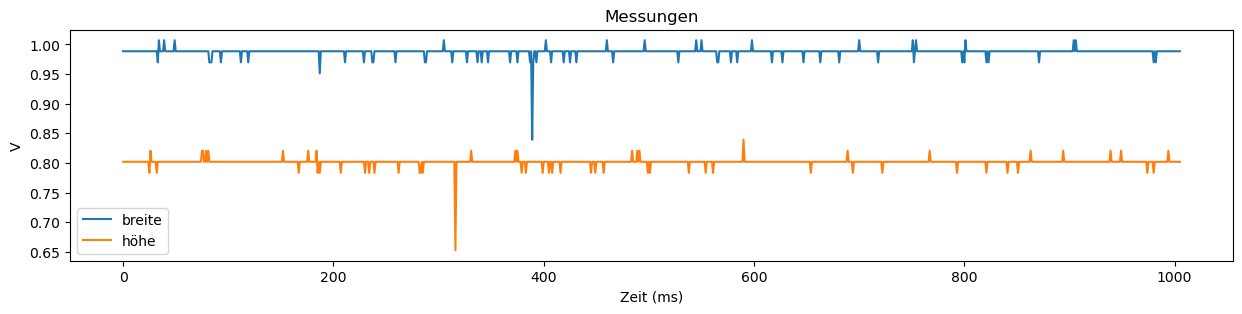

In [17]:
fig, ax = plt.subplots(figsize=(15,3))
ax.set_title("Messungen")
ax.set_ylabel("V")
ax.set_xlabel("Zeit (ms)")
ax.plot(measured_dina4_breite, label="breite")
ax.plot(measured_dina4_hoehe, label="höhe")
ax.legend()

## Berechnung

In [19]:
x1 = measured_dina4_breite_mean
delta_x1 = np.std(measured_dina4_breite)
print("delta_x1 =", delta_x1, "V")

x2 = measured_dina4_hoehe_mean
delta_x2 = np.std(measured_dina4_hoehe)
print("delta_x2 =", delta_x2, "V")

delta_y = np.sqrt((dx1_fl(x1,x2) * delta_x1)**2 + (dx2_fl(x1,x2) * delta_x2)**2)

flaeche = messungs_funktion(x1) * messungs_funktion(x2)

print("delta_y =", delta_y)
print("Fehlerfortpflanzung:", "von", flaeche + delta_y, "mm", "bis", flaeche - delta_y, "mm")

delta_x1 = 0.006717610416243426 V
delta_x2 = 0.006567671534154809 V
delta_y = 1010.1098561499616
Fehlerfortpflanzung: von 60291.47026856923 mm bis 58271.25055626931 mm
